#Import libraries

In [175]:
#import libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#!pip install seaborn
import seaborn as sns
import nltk
import nltk.stem 
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer 
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.corpus import stopwords
import string
import re
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('punkt')
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from sklearn.naive_bayes import BernoulliNB
from wordcloud import WordCloud



[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
# Load data

data = pd.read_csv('https://otf.ca/sites/default/files/OTF-Grants_since2000.csv')

In [39]:
#Set a new index

data_index = pd.Series(range(27953)) 
data = data.set_index([data_index])

In [40]:
#Drop unnecessary columns

data = data.drop(columns=['Funding Org:Org subventionnaire', 'Country Served:Pays servis', 'Province Served:Province servis', 'Cross-catchment indicator:Indicateur interrégional', 'Co-Application:Co-demandeurs', 'Description (French/Français)', 'Grant Result:Résultat de subvention','Rescinded/Recovered:Révoqué/récupéré','Rescinded/Recovered Initiated By:Révoqué/récupéré intié par','Amount Rescinded/Recovered:Montant révoqué/récupéré', 'Last modified:Mise à jour'])
data.columns = ['fiscal_year','grant_program','geographical_area','identifier','org_name','submission_date', 'approval_date', 'amount_applied', 'amount_awarded', 'planned_duration', 'description', 'program_area', 'budget_fund', 'org_incorporation_num', 'org_charitable_reg_num', 'org_city', 'org_postcode', 'population_served', 'age_group']
description = pd.DataFrame(data, columns = ['description'])

#Descriptives - Grant Program Frequency Distribution

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


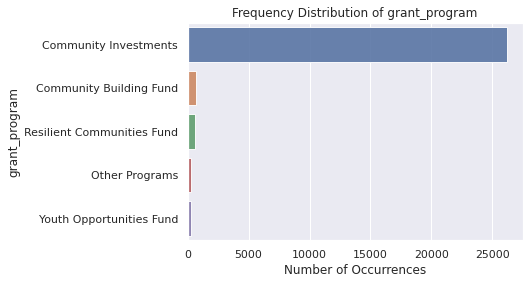

In [181]:
#Examining the data - Grant Program Frequency Distribution

grant_program_count = data['grant_program'].value_counts()
sns.set(style="darkgrid")
sns.barplot(grant_program_count.values, grant_program_count.index, alpha=0.9)
plt.title('Frequency Distribution of grant_program')
plt.ylabel('grant_program', fontsize=12)
plt.xlabel('Number of Occurrences', fontsize=12)
plt.show()

#Data Cleaning

In [41]:
# Preprocessing text - Project description - using regx. Remove structured text and keep only free-form text

a = description['description'].str.split('programs for Ontarians by ').str[1].dropna()
b = description['description'].str.split('grant over \d+ years to ').str[1].dropna()
c = description['description'].str.split('rebuild and recover from impacts of COVID-19 by ').str[1].dropna()
d = description['description'].str.split('grant over \d+ months to ').str[1].dropna()
e = description['description'].str.split('\$\d+( \w+|[\d,]+) over \d+ months to ').str[2].dropna()
f = description['description'].str.split('\$\d+( \w+|[\d,]+) over one year to ').str[2].dropna()
g = description['description'].str.split('\$\d+( \w+|[\d,]+) over two years to ').str[2].dropna()
h = description['description'].str.split('\$\d+( \w+|[\d,]+) over three years to ').str[2].dropna()
i = description['description'].str.split('\$\d+( \w+|[\d,]+) over six months to ').str[2].dropna()
j = description['description'].str.split('This project aims to ').str[1].dropna()

In [42]:
description_clean = pd.concat([a, b, c, d, e, f, g, h, i, j], axis=0,ignore_index=False)
description_clean = description_clean.to_frame()

add_indices = pd.Index(range(27952)).difference(description_clean.index)
add_df = pd.DataFrame(index=add_indices, columns=description_clean.columns).fillna(description)
description_clean = pd.concat([description_clean, add_df])

In [46]:
# Apply lemmatization to reduce redundancy (takes about 2min)
recompute = False

if recompute:
    lemmatizer = WordNetLemmatizer()
        # get_wordnet_pos from Selva Prabhakaran @ Machine Learning Plus
        # https://www.machinelearningplus.com/nlp/lemmatization-examples-python/
    def get_wordnet_pos(word):
            """Map POS tag to first character lemmatize() accepts"""
            tag = nltk.pos_tag([word])[0][1][0].upper()
            tag_dict = {"J": wordnet.ADJ,
                    "N": wordnet.NOUN,
                    "V": wordnet.VERB,
                    "R": wordnet.ADV}
            return tag_dict.get(tag, wordnet.NOUN)

    descriptions = []
    for i in description_clean['description']:
          descriptions.append(' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in nltk.word_tokenize(i.lower())]))

    descriptions=pd.DataFrame(descriptions, columns=['description'])

    def clean_text (df):
        description_C = list()
        lines = descriptions["description"].values.tolist()
        for text in lines:
            text = text.lower()
            text = re.sub(r"i'm", "i am", text)
            text = re.sub(r"he's", "he is", text)
            text = re.sub(r"she's", "she is", text)
            text = re.sub(r"that's", "that is", text)        
            text = re.sub(r"what's", "what is", text)
            text = re.sub(r"where's", "where is", text) 
            text = re.sub(r"\'ll", " will", text)  
            text = re.sub(r"\'ve", " have", text)  
            text = re.sub(r"\'re", " are", text)
            text = re.sub(r"\'d", " would", text)
            text = re.sub(r"\'ve", " have", text)
            text = re.sub(r"won't", "will not", text)
            text = re.sub(r"don't", "do not", text)
            text = re.sub(r"did't", "did not", text)
            text = re.sub(r"can't", "can not", text)
            text = re.sub(r"it's", "it is", text)
            text = re.sub(r"couldn't", "could not", text)
            text = re.sub(r"have't", "have not", text)
            text = re.sub(r"[,.\"!@#$%^&*(){}?/;`~:<>+=-]", "", text)
            tokens = word_tokenize(text)
            table = str.maketrans('', '', string.punctuation)
            stripped = [w.translate(table) for w in tokens]
            words = [word for word in stripped if word.isalpha()]
            stop_words = set(stopwords.words("english"))
            stop_words.discard("not")
            words = [w for w in words if not w in stop_words]
            words = ' '.join(words)
            description_C.append(words)
        return description_C

    description_C = clean_text(descriptions)
    descriptions["description"] = description_C
    pd.DataFrame(descriptions).to_csv('descriptions.csv')
else:
    descriptions = pd.read_csv('descriptions.csv')

#Word Cloud

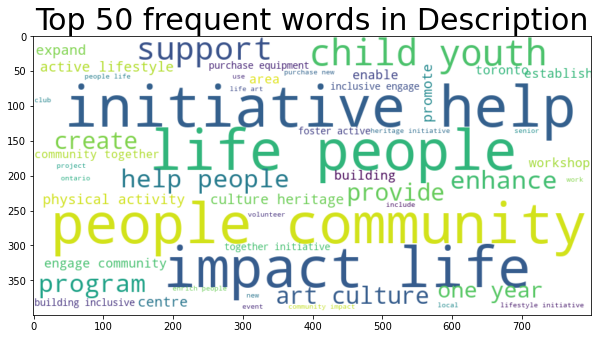

In [50]:
#Visualizing most frequently used words in project descriptions
stop_words = set(stopwords.words('english'))
wc = WordCloud(scale=2, background_color="white", max_words = 50, stopwords = stop_words)
wc.generate(' '.join(descriptions["description"].tolist()))
plt.figure(figsize=(10,7))
plt.title("Top 50 frequent words in Description",fontsize=30)
plt.xlabel("")
plt.ylabel("")
plt.imshow(wc,interpolation='bilinear')

#Feature Extractions

In [55]:
stop_noun = ['ontario', 'year', 'month','toronto','use','ottawa','people'] # Removing stopwords unique to this data
stop_words_full = text.ENGLISH_STOP_WORDS.union(stop_noun)
descriptions.columns = ['description']
vectorizer = TfidfVectorizer(ngram_range=(1,1), max_features = 100, stop_words = stop_words_full) # Extracting features
counts_sparse = vectorizer.fit_transform(descriptions['description'])
Extracted_Features = pd.DataFrame(counts_sparse.toarray(), index=description_clean.index, columns=vectorizer.get_feature_names())
Extracted_Features = Extracted_Features.drop(Extracted_Features.columns[0:11], axis=1) 
Extracted_Features_index = pd.Series(range(27953)) # Establishing index
Extracted_Features = Extracted_Features.set_index([Extracted_Features_index])

#Merging Grant Program column with extracted features
Grant_program = pd.DataFrame (data, columns = ['grant_program'])
Grant_program =pd.concat([Grant_program, Extracted_Features], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


#Model Predictions

## Classifier: Naive Bayes

In [56]:
#Building a model
#Random Training Sample approx 80% of data
#Random_state=1 to maintain order
X1 = Grant_program.sample(22361, random_state=1) 
testing1 = Grant_program.drop(X1.index)

y1 = X1['grant_program']
y1.to_numpy(dtype=None, copy=False)

X1=X1.drop(['grant_program'], axis=1)
X1.to_numpy(dtype=None, copy=False)

t1_y = testing1['grant_program']
t1_y.to_numpy(dtype=None, copy=False)

t1_x=testing1.drop(['grant_program'], axis=1)
t1_x.to_numpy(dtype=None, copy=False)


#StratifiedKFold to preserve the percentage of samples for each class
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
X1_train, X1_validation, y1_train, y1_validation = train_test_split(X1, y1, test_size=0.20, shuffle= True, stratify= y1, random_state= 1)

# Baseline classifier using stratified
classifierNB = DummyClassifier(strategy='stratified') #stratified used due to uneven classes
classifierNB.fit(X1_train, y1_train)

# Baseline accuracy
pred_baselineNB = classifierNB.predict(X1_validation)
baseline_accuracyNB = accuracy_score(y1_validation, pred_baselineNB)
pd.Series(baseline_accuracyNB) 

#Training Model
model_NB = MultinomialNB()
model_NB.fit(X1_train, y1_train)
print('Model_NB is trained on {} data points'.format(X1_train.shape[0]))

#Validation Model
print('Model_NB is validated on {} data points'.format(X1_validation.shape[0]))
ValidationNB = model_NB.predict(X1_validation)
estNB_accuracy = accuracy_score(y1_validation, ValidationNB)

#Testing Model
PredictionNB = model_NB.predict(t1_x)
testNB_accuracy = accuracy_score(t1_y, PredictionNB)

print('Baseline accuracy(NB) score is', baseline_accuracyNB)
print('Estimated NB accuracy is', estNB_accuracy) #Validation accuracy
print('Test NB accuracy is', testNB_accuracy) 


Model_NB is trained on 17888 data points
Model_NB is validated on 4473 data points
Baseline accuracy(NB) score is 0.8808405991504583
Estimated NB accuracy is 0.9369550637156271
Test NB accuracy is 0.9391988555078684


## Classifier: Random Forest

###Random Forest with customized parameters

In [210]:
#Random Forest with customized paramenters
#Building a model
#Random Training Sample approx 80% of data
#Random_state=1 to maintain order
X = Grant_program.sample(22361, random_state=1) 
testing = Grant_program.drop(X.index)

y = X['grant_program']
y.to_numpy(dtype=None, copy=False)

X=X.drop(['grant_program'], axis=1)
X.to_numpy(dtype=None, copy=False)

t_y = testing['grant_program']
t_y.to_numpy(dtype=None, copy=False)

t_x=testing.drop(['grant_program'], axis=1)
t_x.to_numpy(dtype=None, copy=False)


#StratifiedKFold to preserve the percentage of samples for each class
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, shuffle= True, stratify= y, random_state= 1)

# Baseline classifier using stratified
classifier = DummyClassifier(strategy='stratified') #stratified used due to uneven classes
classifier.fit(X_train, y_train)

# Baseline accuracy
pred_baseline = classifier.predict(X_validation)
baseline_accuracy = accuracy_score(y_validation, pred_baseline)
pd.Series(baseline_accuracy) 


#Training Model
feature_scaler = StandardScaler() #Standardize features by removing the mean and scaling to unit variance
X_train_rf = feature_scaler.fit_transform(X_train) #Fit to data, then transform it.
X_validation_rf = feature_scaler.transform(X_validation)

param_grid = { 
        'n_estimators': [200],
    'max_features': ['auto'],
    'max_depth' : [15],
    'criterion' :[ 'entropy'], #information gain
    'min_samples_leaf': [1]
}

rf_clfs = RandomForestClassifier(random_state=1)
rf_clf = GridSearchCV(estimator=rf_clfs, param_grid=param_grid, cv=k_fold,scoring='f1_micro')
rf_clf.fit(X_train_rf,y_train)

print('Model is trained on {} data points'.format(X_train.shape[0]))

#Validation Model
print('Model is validated on {} data points'.format(X_validation.shape[0]))
best_model = rf_clf.best_estimator_
pred = rf_clf.predict(X_validation_rf)
#print('Random Forest F1 on X_test:',f1_score(y_validation, pred, average='micro')*100)

#Testing Model
print('Model is tested on {} data points'.format(t_x.shape[0]))
Prediction = rf_clf.predict(t_x)
#test_accuracy = f1_score(t_y,  Prediction, average='micro')*100

print('Baseline accuracy(RF) score is', baseline_accuracy)
print('Estimated RF accuracy (validation model) is', f1_score(y_validation, pred, average='micro')*100) 
print('Test RF accuracy is', f1_score(t_y, Prediction, average='micro')*100)

Model is trained on 17888 data points
Model is validated on 4473 data points
Model is tested on 5592 data points


/usr/local/lib/python3.7/dist-packages/sklearn/base.py:439: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  f"X has feature names, but {self.__class__.__name__} was fitted without"


Baseline accuracy(RF) score is 0.8759221998658618
Estimated RF accuracy (validation model) is 94.94746255309636
Test RF accuracy is 93.72317596566523


###Random Forest with default parameters

In [62]:
#Random Forest with default parameters
#Building a model
#Random Training Sample approx 80% of data
#Random_state=1 to maintain order
X = Grant_program.sample(22361, random_state=1) 
testing = Grant_program.drop(X.index)

y = X['grant_program']
y.to_numpy(dtype=None, copy=False)

X=X.drop(['grant_program'], axis=1)
X.to_numpy(dtype=None, copy=False)

t_y = testing['grant_program']
t_y.to_numpy(dtype=None, copy=False)

t_x=testing.drop(['grant_program'], axis=1)
t_x.to_numpy(dtype=None, copy=False)


#StratifiedKFold to preserve the percentage of samples for each class
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=1)
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, shuffle= True, stratify= y, random_state= 1)

# Baseline classifier using stratified
classifier = DummyClassifier(strategy='stratified')
classifier.fit(X_train, y_train)

# Baseline accuracy
pred_baseline = classifier.predict(X_validation)
baseline_accuracy = accuracy_score(y_validation, pred_baseline)
pd.Series(baseline_accuracy) 

#Training Model
model = RandomForestClassifier(random_state=1)
model.fit(X_train, y_train)
print('Model is trained on {} data points'.format(X_train.shape[0]))

#Validation Model
print('Model is validated on {} data points'.format(X_validation.shape[0]))
Validation = model.predict(X_validation)
est_accuracy = accuracy_score(y_validation, Validation)


#Testing Model
print('Model is tested on {} data points'.format(t_x.shape[0]))
Prediction = model.predict(t_x)
test_accuracy = accuracy_score(t_y, Prediction)

print('Baseline accuracy(RF) score is', baseline_accuracy)
print('Estimated RF accuracy (validation model) is', est_accuracy) #Validation accuracy
print('Test RF accuracy is', test_accuracy) 

#Random Forest outperformed MultinomialNB therefore the RF classifier was used in the final model. 
#Default RFparameters outperformed customized parameters and were retained for the final model

Model is trained on 17888 data points
Model is validated on 4473 data points
Model is tested on 5592 data points
Baseline accuracy(RF) score is 0.8750279454504807
Estimated RF accuracy (validation model) is 0.9488039347194277
Test RF accuracy is 0.9508226037195995


[[  66   47    0    7    0]
 [  11 5216    9    3    2]
 [   0   45    2    0    0]
 [   7   80    0   33    0]
 [   0   64    0    0    0]]
                            precision    recall  f1-score   support

   Community Building Fund       0.79      0.55      0.65       120
     Community Investments       0.96      1.00      0.98      5241
            Other Programs       0.18      0.04      0.07        47
Resilient Communities Fund       0.77      0.28      0.40       120
  Youth Opportunities Fund       0.00      0.00      0.00        64

                  accuracy                           0.95      5592
                 macro avg       0.54      0.37      0.42      5592
              weighted avg       0.93      0.95      0.94      5592



Text(0.5, 15.0, 'Predicted score')

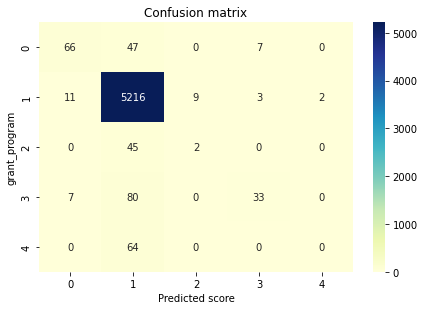

In [63]:

#Visualizing the Validation RF Model's Performance

cnf_matrixRF = metrics.confusion_matrix(t_y, Prediction)
print(cnf_matrixRF)
print(classification_report(t_y, Prediction))
fig, ax = plt.subplots()
sns.heatmap(pd.DataFrame(cnf_matrixRF), annot=True, cmap="YlGnBu" ,fmt='g')
plt.tight_layout()
plt.title('Confusion matrix')    
plt.ylabel('grant_program')
plt.xlabel('Predicted score')


#K means cluster

###Range 2-20

In [ ]:
# Scale Extracted_Features from 0 to 1
Extracted_Features_scaled =  (Extracted_Features - Extracted_Features.min()) / (Extracted_Features.max() - Extracted_Features.min())

# Plot the silhouette

silhouette_list = []
for k in range(2,20): #range chosen to match current 5 grant categories
    model1 = KMeans(n_clusters=k)
    model1.fit(Extracted_Features_scaled)
    cluster_id = pd.Series(model1.predict(Extracted_Features_scaled))
    
    # The two following lines are equivalent
    silhouette1 = silhouette_score(Extracted_Features_scaled, cluster_id)
    #silhouette = silhouette_samples(counts_r_scaled, cluster_id).mean()
    
    silhouette_list.append({'k':k, 'silhouette_score':silhouette_score(Extracted_Features_scaled, cluster_id), 'label':cluster_id})


# Select best labels (based on silhouette score)
silhouette_list1=pd.DataFrame(silhouette_list)
best_label1 = silhouette_list1.loc[silhouette_list1['silhouette_score'].idxmax(),'label']
best_label1


ax = pd.DataFrame(silhouette_list).set_index('k').plot.line()
ax.set_ylabel('Silhouette Score')

Text(0, 0.5, 'Silhouette Score')

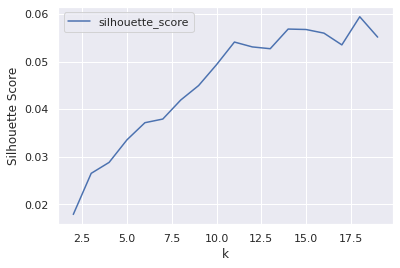

In [190]:
silhouette_list1=pd.DataFrame(silhouette_list)
best_label1 = silhouette_list1.loc[silhouette_list1['silhouette_score'].idxmax(),'label']
best_label1


ax = pd.DataFrame(silhouette_list).set_index('k').plot.line()
ax.set_ylabel('Silhouette Score')

###Range 2-10

Text(0, 0.5, 'Silhouette Score')

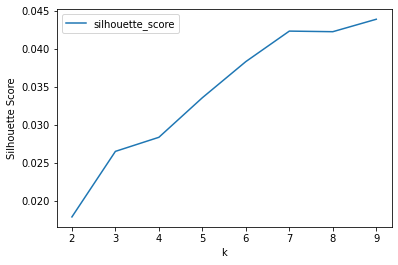

In [64]:
# Scale Extracted_Features from 0 to 1
Extracted_Features_scaled =  (Extracted_Features - Extracted_Features.min()) / (Extracted_Features.max() - Extracted_Features.min())

# Plot the silhouette

silhouette_list = []
for k in range(2,10): #range chosen to match current 5 grant categories
    model = KMeans(n_clusters=k)
    model.fit(Extracted_Features_scaled)
    cluster_id = pd.Series(model.predict(Extracted_Features_scaled))
    
    # The two following lines are equivalent
    silhouette = silhouette_score(Extracted_Features_scaled, cluster_id)
    #silhouette = silhouette_samples(counts_r_scaled, cluster_id).mean()
    
    silhouette_list.append({'k':k, 'silhouette_score':silhouette_score(Extracted_Features_scaled, cluster_id), 'label':cluster_id})


# Select best labels (based on silhouette score)
silhouette_list=pd.DataFrame(silhouette_list)
best_label = silhouette_list.loc[silhouette_list['silhouette_score'].idxmax(),'label']
best_label


ax = pd.DataFrame(silhouette_list).set_index('k').plot.line()
ax.set_ylabel('Silhouette Score')

##Apply k

####3 Clusters

In [ ]:
#Use K means to cluster extracted features
# Apply k
recompute = False

if recompute:
    k_model3 = KMeans(n_clusters=3)
    k_model3.fit(Extracted_Features_scaled)
    cluster_assignment3 = k_model3.predict(Extracted_Features_scaled)
    clusters3=Extracted_Features_scaled.groupby(cluster_assignment3).mean()
    clusters3

    clusters_index3 = pd.Series(range(3))
    clusters3['clusters3']=clusters_index3

    # convert the dataframes into a long format
    clusters3.set_index(['clusters3'], inplace=True)
    clusters3.columns.names = ['Features3']
    weights = clusters3.stack().to_frame()
    weights.columns = ['weights']
    clusters3=weights

    #reset index
    clusters3 = clusters3.reset_index()

    #sort data by clusters and weights
    clusters3=clusters3.sort_values(by=['clusters3','weights'], ascending=[True,False])
    clusters3.to_csv('clusters3.csv', index=False)
    clusters3
else:
    clusters3 = pd.read_csv('clusters3.csv')


In [ ]:
clusters3_top5 = clusters3.groupby(["clusters3"]).apply(lambda x: x.sort_values(["weights"], ascending = False)).reset_index(drop=True)
clusters3_top5=clusters3_top5.groupby('clusters3').head(5)
clusters3_top5

,clusters3,Features3,weights
0,0,purchase,0.243507
1,0,equipment,0.237677
2,0,new,0.087048
3,0,program,0.060218
4,0,community,0.060210
89,1,life,0.272538
90,1,community,0.244174
91,1,impact,0.230109
92,1,initiative,0.229714
93,1,help,0.200298


###4 Clusters

In [159]:
#Use K means to cluster extracted features
# Apply k
recompute = False

if recompute:
    k_model4 = KMeans(n_clusters=4)
    k_model4.fit(Extracted_Features_scaled)
    cluster_assignment4 = k_model4.predict(Extracted_Features_scaled)
    clusters4=Extracted_Features_scaled.groupby(cluster_assignment4).mean()
    clusters4

    clusters_index4 = pd.Series(range(4))
    clusters4['clusters4']=clusters_index4

    # convert the dataframes into a long format
    clusters4.set_index(['clusters4'], inplace=True)
    clusters4.columns.names = ['Features4']
    weights = clusters4.stack().to_frame()
    weights.columns = ['weights']
    clusters4=weights

    #reset index
    clusters4 = clusters4.reset_index()

    #sort data by clusters and weights
    clusters4=clusters4.sort_values(by=['clusters4','weights'], ascending=[True,False])
    clusters4.to_csv('clusters4.csv', index=False)
    clusters4
else:
    clusters4 = pd.read_csv('clusters4.csv')

In [211]:
clusters4_top5 = clusters4.groupby(["clusters4"]).apply(lambda x: x.sort_values(["weights"], ascending = False)).reset_index(drop=True)
clusters4_top5=clusters4_top5.groupby('clusters4').head(5)
clusters4_top5.to_csv('clusters4_top5.csv', index=False)
clusters4_top5

,clusters4,Features4,weights
0,0,youth,0.314619
1,0,child,0.179911
2,0,program,0.141776
3,0,support,0.093815
4,0,skill,0.093659
89,1,purchase,0.246889
90,1,equipment,0.244892
91,1,new,0.089276
92,1,community,0.061887
93,1,safety,0.057613


###6 Clusters - Retain as best grouping

In [192]:
#Use K means to cluster extracted features
# Apply k
recompute = False

if recompute:
    k_model6 = KMeans(n_clusters=6)
    k_model6.fit(Extracted_Features_scaled)
    cluster_assignment6 = k_model6.predict(Extracted_Features_scaled)
    clusters6=Extracted_Features_scaled.groupby(cluster_assignment6).mean()
    clusters6

    clusters_index6 = pd.Series(range(6))
    clusters6['clusters6']=clusters_index6

    # convert the dataframes into a long format
    clusters6.set_index(['clusters6'], inplace=True)
    clusters6.columns.names = ['Features6']
    weights = clusters6.stack().to_frame()
    weights.columns = ['weights']
    clusters6=weights

    #reset index
    clusters6 = clusters6.reset_index()

    #sort data by clusters and weights
    clusters6=clusters6.sort_values(by=['clusters6','weights'], ascending=[True,False])
    clusters6.to_csv('clusters6.csv', index=False)
    clusters6

else:
    clusters6 = pd.read_csv('clusters6.csv')

In [194]:
clusters6_top5 = clusters6.groupby(["clusters6"]).apply(lambda x: x.sort_values(["weights"], ascending = False)).reset_index(drop=True)
clusters6_top5=clusters6_top5.groupby('clusters6').head(5)
clusters6_top5.to_csv('clusters6_top5.csv', index=False)
clusters6_top5

,clusters6,Features6,weights
0,0,youth,0.374281
1,0,child,0.152739
2,0,program,0.130593
3,0,skill,0.100123
4,0,support,0.097540
89,1,purchase,0.303388
90,1,equipment,0.237906
91,1,new,0.095677
92,1,community,0.060803
93,1,provide,0.056222


###7 Clusters

In [ ]:
#Use K means to cluster extracted features
# Apply k
recompute = False

if recompute:
    k_model7 = KMeans(n_clusters=7)
    k_model7.fit(Extracted_Features_scaled)
    cluster_assignment7 = k_model7.predict(Extracted_Features_scaled)
    clusters7=Extracted_Features_scaled.groupby(cluster_assignment7).mean()
    clusters7

    clusters_index7 = pd.Series(range(7))
    clusters7['clusters7']=clusters_index7

    # convert the dataframes into a long format
    clusters7.set_index(['clusters7'], inplace=True)
    clusters7.columns.names = ['Features7']
    weights = clusters7.stack().to_frame()
    weights.columns = ['weights']
    clusters7=weights

    #reset index
    clusters7 = clusters7.reset_index()

    #sort data by clusters and weights
    clusters7=clusters7.sort_values(by=['clusters7','weights'], ascending=[True,False])
    clusters7.to_csv('clusters7.csv', index=False)
    clusters7

else:
    clusters7 = pd.read_csv('clusters7.csv')

In [166]:
clusters7_top5 = clusters7.groupby(["clusters7"]).apply(lambda x: x.sort_values(["weights"], ascending = False)).reset_index(drop=True)
clusters7_top5=clusters7_top5.groupby('clusters7').head(5)
clusters7_top5.to_csv('clusters7_top5.csv', index=False)
clusters7_top5

,clusters7,Features7,weights
0,0,purchase,0.317796
1,0,equipment,0.233675
2,0,new,0.095257
3,0,community,0.063897
4,0,provide,0.059027
89,1,program,0.140112
90,1,support,0.129596
91,1,develop,0.087186
92,1,volunteer,0.071598
93,1,staff,0.065780


###9 Clusters

In [167]:
#Use K means to cluster extracted features
# Apply k
recompute = False

if recompute:
    k_model9 = KMeans(n_clusters=9)
    k_model9.fit(Extracted_Features_scaled)
    cluster_assignment9 = k_model9.predict(Extracted_Features_scaled)
    clusters9=Extracted_Features_scaled.groupby(cluster_assignment9).mean()
    clusters9

    clusters_index9 = pd.Series(range(9))
    clusters9['clusters9']=clusters_index9

    # convert the dataframes into a long format
    clusters9.set_index(['clusters9'], inplace=True)
    clusters9.columns.names = ['Features9']
    weights = clusters9.stack().to_frame()
    weights.columns = ['weights']
    clusters9=weights

    #reset index
    clusters9 = clusters9.reset_index()

    #sort data by clusters and weights
    clusters9=clusters9.sort_values(by=['clusters9','weights'], ascending=[True,False])
    clusters9.to_csv('clusters9.csv', index=False)
    clusters9

else:
    clusters9 = pd.read_csv('clusters9.csv')

In [168]:
clusters9_top5 = clusters9.groupby(["clusters9"]).apply(lambda x: x.sort_values(["weights"], ascending = False)).reset_index(drop=True)
clusters9_top5=clusters9_top5.groupby('clusters9').head(5)
clusters9_top5.to_csv('clusters9_top5.csv', index=False)
clusters9_top5

,clusters9,Features9,weights
0,0,purchase,0.312162
1,0,equipment,0.238033
2,0,new,0.098551
3,0,community,0.062883
4,0,safety,0.058232
89,1,community,0.086798
90,1,program,0.072441
91,1,provide,0.056993
92,1,increase,0.055676
93,1,develop,0.053009


In [197]:
#merge extracted features to data
#Drop unecessary columns

Merged_data = pd.concat([data, Extracted_Features], axis=1)
Merged_data = Merged_data.drop(['amount_awarded', 'geographical_area',	'identifier','planned_duration',
             'org_name',	'submission_date',	'approval_date',	'amount_applied',	'description',	
             'program_area',	'budget_fund',	'org_incorporation_num',	'org_charitable_reg_num',
             'org_city',	'org_postcode',	'population_served',	'age_group'], axis=1)


#Add cluster assignment column
Merged_data['cluster_assignment6']=cluster_assignment6

#Recode Grant Program and Fiscal Year string data
# creating a dict file 
grants = {'Community Building Fund': 1,'Community Investments': 2, 'Other Programs':3, 'Resilient Communities Fund':4, 'Youth Opportunities Fund':5 }
year = {'2021-2022':2021, '2020-2021':2020, '2019-2020':2019, '2018-2019':2018, '2017-2018':2017,
       '2016-2017':2016, '2015-2016':2015, '2014-2015':2014, '2013-2014':2013, '2012-2013':2012,
       '2011-2012':2011, '2010-2011':2010, '2009-2010':2009, '2008-2009':2008, '2007-2008':2007,
       '2006-2007':2006, '2005-2006':2005, '2004-2005':2004, '2003-2004':2003, '2002-2003':2002,
       '2001-2002':2001, '2000-2001':2000, '1999-2000':1999}
  

# traverse through dataframe and writing values where key matches  
Merged_data.grant_program = [grants[item] for item in Merged_data.grant_program]
Merged_data.fiscal_year = [year[item] for item in Merged_data.fiscal_year]


### Examining Grant Program distribution over the last 20 years

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[Text(0, 0, 'Community Building Fund'),
 Text(0, 0, 'Community Investments'),
 Text(0, 0, 'Other Programs'),
 Text(0, 0, 'Resilient Communities Fund'),
 Text(0, 0, 'Youth Opportunities Fund')]

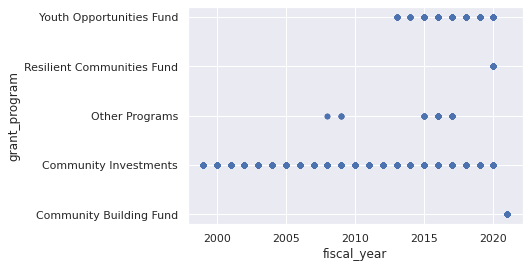

In [182]:
# Examining Grant Program distribution over the last 20 years

sns.set(style="darkgrid")
ax = Merged_data.plot.scatter('fiscal_year','grant_program')#, color=Merged_data['grant_program'].map(color_mapping))
plt.yticks(range(1, 6))
ax.set_yticklabels(('Community Building Fund','Community Investments', 'Other Programs', 'Resilient Communities Fund', 'Youth Opportunities Fund'))

[Text(0, 0, 'Youth and Child'),
 Text(0, 0, 'Purchase New Equipment'),
 Text(0, 0, 'Programme Support'),
 Text(0, 0, 'Building Fund'),
 Text(0, 0, 'Organization Capacity Building'),
 Text(0, 0, 'Community Impact')]

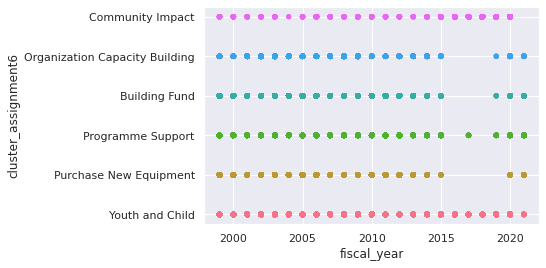

In [200]:
# Examining Cluster distribution over the last 20 years

colors = sns.color_palette('husl', n_colors=Merged_data['cluster_assignment6'].nunique()) 
colors_mapping = {x:colors[x] for x in Merged_data['cluster_assignment6'].unique()}

ax = Merged_data.plot.scatter('fiscal_year','cluster_assignment6', color=Merged_data['cluster_assignment6'].map(colors_mapping))
plt.yticks(range(0, 6))
ax.set_yticklabels(('Youth and Child Fund','Purchase New Equipment', 'Programme Support', 'Building Fund', 'Organization Capacity Building','Community Impact'))

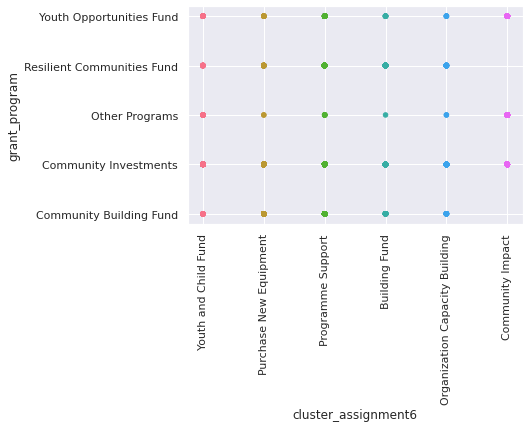

In [209]:
ax = Merged_data.plot.scatter('cluster_assignment6', 'grant_program', color=Merged_data['cluster_assignment6'].map(colors_mapping))
plt.yticks(range(1, 6))
ax.set_yticklabels(('Community Building Fund','Community Investments', 'Other Programs', 'Resilient Communities Fund', 'Youth Opportunities Fund'))
plt.xticks(range(0, 6))
ax.set_xticklabels(('Youth and Child Fund','Purchase New Equipment', 'Programme Support', 'Building Fund', 'Organization Capacity Building','Community Impact'))
for item in ax.get_xticklabels():
    item.set_rotation(90)